In [37]:
%pip install pandas sqlalchemy mysql-connector-python matplotlib dotenv scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 47.7 MB/s  0:00:00 eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
def load_password(env_variable):
    load_dotenv()  # Loads variables from .env file
    return os.getenv(env_variable)


In [15]:
def get_df_from_mysql(sql_request, mysql_engine):
    return pd.read_sql(sql_request, con=mysql_engine)

In [16]:
def init_mysql_engine(username, password, host, database):
    port = 3306
    connection_string = f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}"
    return create_engine(connection_string)

In [17]:
# Replace these with your actual credentials:
username = "root"
password = load_password('MYSQL_PASSWORD')
host     = "localhost"
port     = 3306
database = "airline_db"

# Create the connection string
engine = init_mysql_engine(username=username, password=password, host=host, database=database)

In [23]:
# Gender distribution
query_gender = '''
SELECT gender,
       COUNT(*) AS count
FROM passenger
GROUP BY gender;
'''
df_gender = pd.read_sql(query_gender, engine)

# Average passenger age
query_avg_age = '''
SELECT AVG(age) AS avg_age
FROM passenger;
'''
df_avg_age = pd.read_sql(query_avg_age, engine)


In [57]:
# Top 5 countries with most airports
query_top_countries = '''
SELECT iso_country,
       COUNT(*) AS airport_count
FROM airport
GROUP BY iso_country
ORDER BY airport_count DESC
LIMIT 5;
'''
df_top_countries = pd.read_sql(query_top_countries, engine)

# Top 5 arrival airports by flights
query_top_airports = '''
SELECT 
       f.arrival_airport AS arrival_airport_code,
       a.name AS arrival_airport,
       COUNT(*) AS flights
FROM flight AS f
JOIN airport AS a
  ON f.arrival_airport = a.airport_code
GROUP BY f.arrival_airport
ORDER BY flights DESC
LIMIT 5;
'''
df_top_airports = pd.read_sql(query_top_airports, engine)

# Airports with most delays
query_airport_delays = '''
SELECT 
  f.arrival_airport AS arrival_airport_code,
  a.name AS arrival_airport,
  COUNT(*) AS delays
FROM flight AS f
JOIN airport AS a
  ON f.arrival_airport = a.airport_code
WHERE f.flight_status = 'delayed'
GROUP BY f.arrival_airport
ORDER BY delays DESC;
'''
df_airport_delays = pd.read_sql(query_airport_delays, engine)


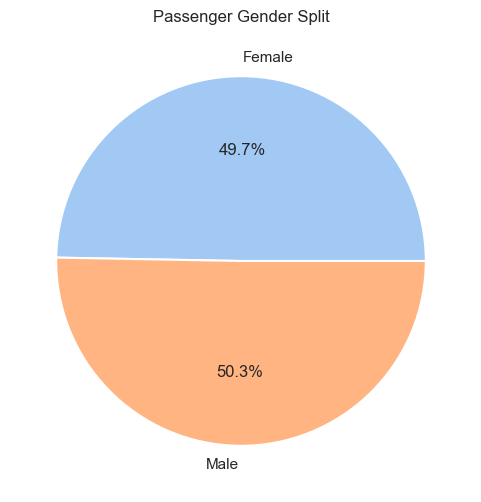

/var/folders/9x/t81_t1w14_s8w2jy_nx_xn4m0000gn/T/ipykernel_53098/1352786157.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='nationality', y='count', data=df_nationalities, palette='Set2')


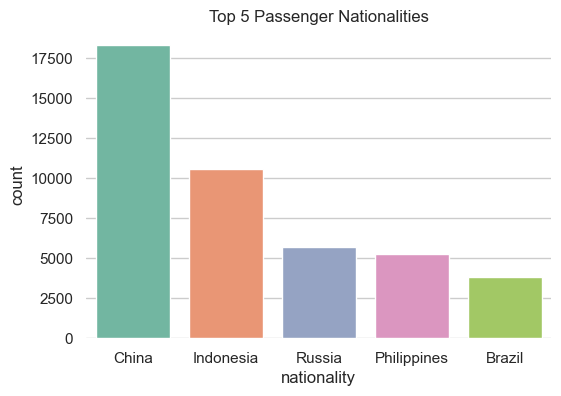

/var/folders/9x/t81_t1w14_s8w2jy_nx_xn4m0000gn/T/ipykernel_53098/1352786157.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='continent', y='count', data=df_airport_continent, palette=colors)
/var/folders/9x/t81_t1w14_s8w2jy_nx_xn4m0000gn/T/ipykernel_53098/1352786157.py:37: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(x='continent', y='count', data=df_airport_continent, palette=colors)


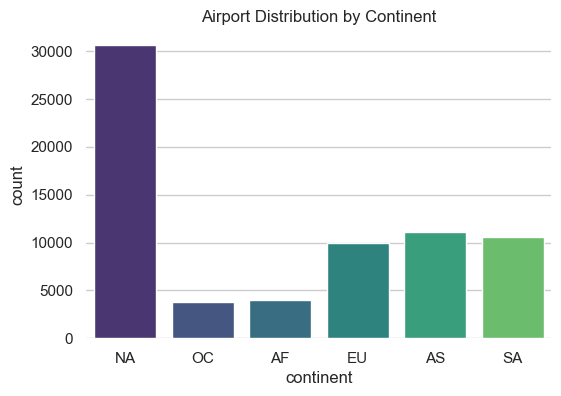

In [58]:
# Pie chart: Passenger gender split
colors = sns.color_palette("pastel", 2)
plt.figure(figsize=(6,6))
plt.pie(df_gender['count'], labels=df_gender['gender'], autopct='%1.1f%%', colors=colors, wedgeprops={'edgecolor': 'white', 'linewidth': 1.5})
plt.title('Passenger Gender Split')
plt.show()

# Bar chart: Top 5 nationalities by passenger count
query_nationalities = '''
SELECT nationality,
       COUNT(*) AS count
FROM passenger
GROUP BY nationality
ORDER BY count DESC
LIMIT 5;
'''
df_nationalities = pd.read_sql(query_nationalities, engine)

plt.figure(figsize=(6,4))
sns.barplot(x='nationality', y='count', data=df_nationalities, palette='Set2')
plt.title('Top 5 Passenger Nationalities')
sns.despine(left=True, bottom=True)
plt.show()

# Bar chart: Airport distribution by continent
query_airport_continent = '''
SELECT continent,
       COUNT(*) AS count
FROM airport
GROUP BY continent;
'''
df_airport_continent = pd.read_sql(query_airport_continent, engine)

colors = sns.color_palette("viridis", n_colors=df_airport_continent.shape[0])

plt.figure(figsize=(6,4))
sns.barplot(x='continent', y='count', data=df_airport_continent, palette=colors)
plt.title('Airport Distribution by Continent')
sns.despine(left=True, bottom=True)
plt.show()


/var/folders/9x/t81_t1w14_s8w2jy_nx_xn4m0000gn/T/ipykernel_53098/4125293240.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


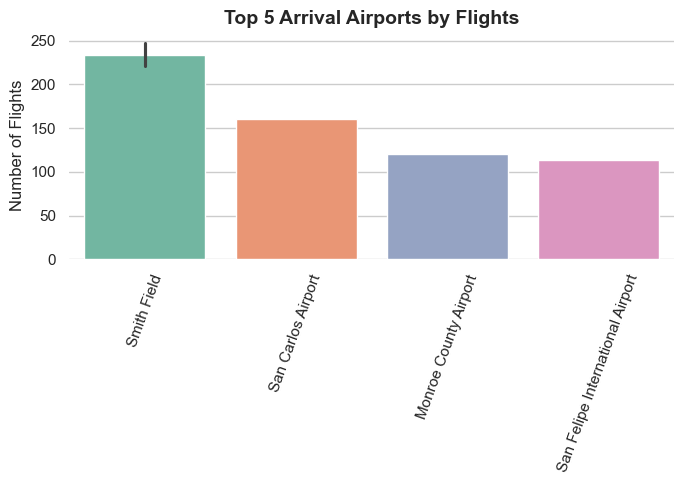

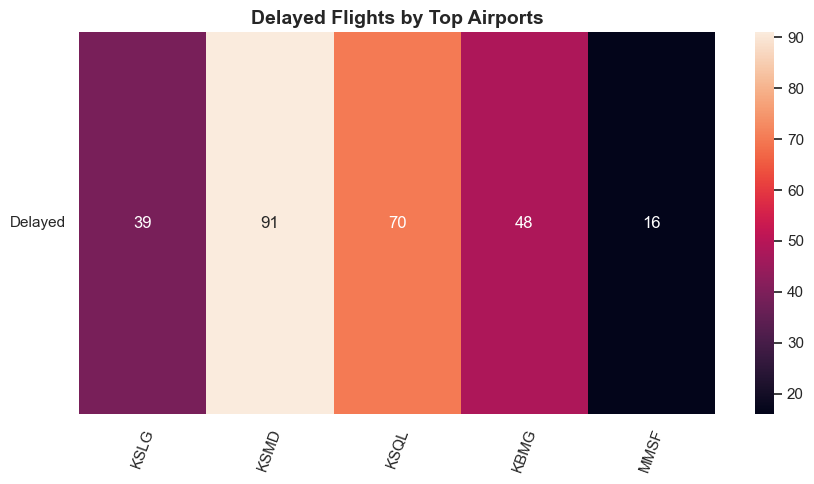

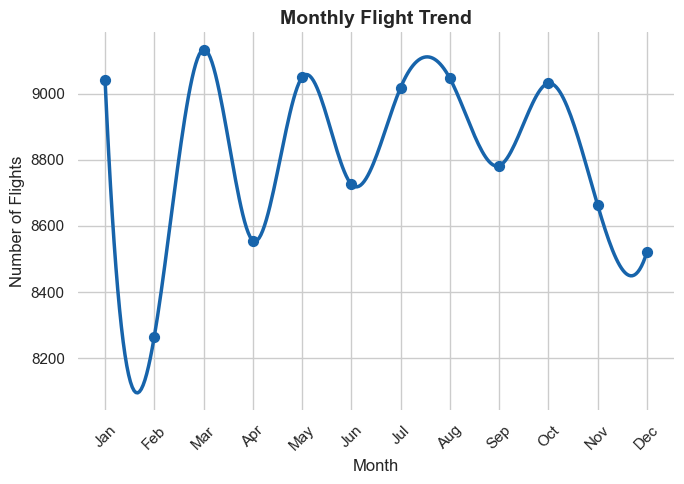

In [62]:
# Bar chart: Top 5 arrival airports by number of flights
plt.figure(figsize=(7, 5))
sns.barplot(
    x='arrival_airport',
    y='flights',
    data=df_top_airports,
    palette='Set2'
)
plt.title('Top 5 Arrival Airports by Flights', fontsize=14, fontweight='semibold')
plt.xlabel('')
plt.ylabel('Number of Flights')
plt.xticks(rotation=70)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# Heatmap: Delayed flights by airport
import numpy as np

delay_counts = (
    df_airport_delays
    .set_index('arrival_airport_code')['delays']
    .reindex(df_top_airports['arrival_airport_code'])
    .fillna(0)
)

plt.figure(figsize=(9, 5))
sns.heatmap(
    delay_counts.values[np.newaxis, :],
    annot=True,
    fmt='g',
    cmap='rocket',
    cbar_kws={ 'pad': 0.05},
    # cbar_kws={'orientation': 'horizontal', 'pad': 0.2},
    xticklabels=delay_counts.index,
    yticklabels=['Delayed']
)
plt.title('Delayed Flights by Top Airports', fontsize=14, fontweight='semibold')
plt.xlabel('')
plt.yticks(rotation=0)
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

# Line chart: Monthly flight trend
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import calendar
from scipy.interpolate import make_interp_spline

# Map month numbers to names and ensure all months are present
df_monthly_trend['month_name'] = df_monthly_trend['month'].apply(lambda m: calendar.month_name[m])
df_full = (
    df_monthly_trend
    .set_index('month')
    .reindex(range(1, 13), fill_value=0)
    .reset_index()
)
df_full['month_name'] = df_full['month'].apply(lambda m: calendar.month_name[m])

# Create a smooth spline
x = df_full['month'].values
y = df_full['flights'].values
x_smooth = np.linspace(x.min(), x.max(), 300)
spline = make_interp_spline(x, y, k=3)
y_smooth = spline(x_smooth)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(
    x_smooth,
    y_smooth,
    color=sns.color_palette('Blues', 4)[-1],
    linewidth=2.5
)
plt.scatter(
    df_full['month'],
    df_full['flights'],
    color=sns.color_palette('Blues', 4)[-1],
    s=50
)
plt.title('Monthly Flight Trend', fontsize=14, fontweight='semibold')
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.xticks(
    ticks=range(1, 13),
    labels=[calendar.month_abbr[m] for m in range(1, 13)],
    rotation=45
)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
